# Potencial Ornitológico Fueguino
### **Autor:** Pablo Jusim

# Script principal del modelado

En este script se realizará la **creación**, **entrenamiento** y **evaluación** del modelo de aprendizaje automático.

### **Objetivo**
Clasificar cada área de la provincia de Tierra del Fuego según su potencial ornitológico.

Se utilizarán módulos de Python creados para este proyecto además de módulos de terceros.

El preprocesamiento de los datos se realizará en otros notebook (01a, 01b y 02) dentro de este proyecto.

El producto obtenido del modelado se continua procesando en otro notebook (03) para generar la grilla espacial final. El producto final del trabajo es un mapa que se genera en Qgis a partir de la griila obtenida mediante el modelo.


## Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.preprocessing import  normalize, MinMaxScaler
from sklearn.feature_extraction.text import TfidfTransformer
import geopandas as gpd
from pathlib import Path
import sys

sys.path.append(str(Path('..')/'src'))
import utils
import etl_ebird
import etl_inat
import grid_generation
import merge_sources
import postprocess_grid
import postprocess_map

## Carga de datos y configuración general

#### Rutas de los datos a usar en el notebook
Rutas de datos de ejemplo. Cambiar para trabajar con datos propios

In [3]:
# Path to data from eBird
PATH_DATA_EBIRD = '../data/external/obs_ebird.txt'
# Path to data from iNaturalist
PATH_DATA_INAT = '../data/external/obs_iNat.csv'
# Path to contour for grid limits
CONTOUR_PATH = '../data/external/contorno_tdf.gpkg'

#### Parámetros generales
Se pueden cambiar según la necesidad

In [4]:
# Code epsg (geodesic system)
EPSG_CODE = 4326
# Grid cell side lenght (in kilometers)
CELL_SIZE = 5
# Maximum aceptable distance for iNaturalist's observation's accuracy (in meters)
MAX_ACCURACY = CELL_SIZE / 2


### Data loaded

In [5]:
data_ebird = etl_ebird.main(Path(PATH_DATA_EBIRD))  # eBird
data_inat = etl_inat.main(Path(PATH_DATA_INAT))  # iNaturalist

c:\Users\pablo\OneDrive\Estudio\Tecnicatura Cs datos e IA\3er cuatri\Aprendizaje automático\Parcial\Proyecto final\Potencial-ornitologico-fueguino\notebooks\..\src\etl_ebird.py:65: DtypeWarning: Columns (11,12,13,14,33,38) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(filepath, sep='\t')


2025-06-24 10:16:05,288 [INFO] Loaded 426837 raw eBird records from C:\Users\pablo\OneDrive\Estudio\Tecnicatura Cs datos e IA\3er cuatri\Aprendizaje automático\Parcial\Proyecto final\Potencial-ornitologico-fueguino\src\..\data\external\obs_ebird.txt
2025-06-24 10:16:05,311 [INFO] Selected and renamed columns: ['common_name', 'scientific_name', 'latitude', 'longitude', 'observed_on']
2025-06-24 10:16:06,299 [INFO] Exported cleaned data to C:\Users\pablo\OneDrive\Estudio\Tecnicatura Cs datos e IA\3er cuatri\Aprendizaje automático\Parcial\Proyecto final\Potencial-ornitologico-fueguino\data\raw\data_ebird.csv
2025-06-24 10:16:06,436 [INFO] Loaded 15651 raw records from C:\Users\pablo\OneDrive\Estudio\Tecnicatura Cs datos e IA\3er cuatri\Aprendizaje automático\Parcial\Proyecto final\Potencial-ornitologico-fueguino\src\..\data\external\obs_iNat.csv
2025-06-24 10:16:06,440 [INFO] Filtered by accuracy < 2500m: 8087 records remain
2025-06-24 10:16:06,445 [INFO] Normalized scientific names to ge

## Creación de base de datos para modelado

### Creación de grilla espacial
Dentro del contorno indicado

In [6]:
grid_generation.main(
    contour_path=CONTOUR_PATH,
    epsg_code=EPSG_CODE,
    cell_size=CELL_SIZE
    )

2025-06-24 10:16:06,487 [INFO] Loaded contour: C:\Users\pablo\OneDrive\Estudio\Tecnicatura Cs datos e IA\3er cuatri\Aprendizaje automático\Parcial\Proyecto final\Potencial-ornitologico-fueguino\src\..\data\external\contorno_tdf.gpkg
2025-06-24 10:16:06,506 [INFO] Generated 2484 grid points
2025-06-24 10:16:07,025 [INFO] Filtered to 916 cells within contour
2025-06-24 10:16:07,053 [INFO] Created 916 records
2025-06-24 10:16:07,074 [INFO] Grid exported to ..\data\raw\grilla_tdf_vacia.gpkg


### Creación de dataframe unificado de eBird e iNaturalist
Y asociación de los registros a la celda correspondiente de la grilla espacial

In [7]:
merge_sources.main()

2025-06-24 10:16:07,334 [INFO] Loaded and merged: 434924 total observations
2025-06-24 10:16:17,465 [INFO] Assigned grid cells: 406904 records
2025-06-24 10:16:17,501 [INFO] Filtered rare species (<=5): 406793 records


c:\Users\pablo\OneDrive\Estudio\Tecnicatura Cs datos e IA\3er cuatri\Aprendizaje automático\Parcial\Proyecto final\Potencial-ornitologico-fueguino\notebooks\..\src\merge_sources.py:118: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_no_rare['scientific_name'] = df_no_rare['scientific_name'].str.strip()


2025-06-24 10:16:17,839 [INFO] Removed erroneous names: 404164 records
2025-06-24 10:16:17,887 [INFO] Created species counts for 393 cells
2025-06-24 10:16:17,897 [INFO] Exported final counts to C:\Users\pablo\OneDrive\Estudio\Tecnicatura Cs datos e IA\3er cuatri\Aprendizaje automático\Parcial\Proyecto final\Potencial-ornitologico-fueguino\data\interim\grilla_tdf_spp.csv


## Preprocesamiento

### Carga de base de datos unificada y grillada

In [8]:
MERGED_DATA_PATH = '../data/interim/grilla_tdf_spp.csv'
try:
    df = pd.read_csv(MERGED_DATA_PATH)
except FileNotFoundError:
    print('No se encuentra el archivo en la ruta ' + MERGED_DATA_PATH)

### Métricas exploratorias

#### Forma de los datos

In [9]:
print(f'cells: {df.shape[0]}  /  species: {df.shape[1]}')
print(df.columns.values)

cells: 393  /  species: 179
['grid_id' 'Anairetes parulus' 'Anarhynchus falklandicus'
 'Anas bahamensis' 'Anas flavirostris' 'Anas georgica' 'Anser anser'
 'Anthus correndera' 'Aphrastura spinicauda' 'Aptenodytes patagonicus'
 'Ardea ibis' 'Ardenna gravis' 'Ardenna grisea' 'Arenaria interpres'
 'Asio flammeus' 'Asthenes anthoides' 'Astur chilensis'
 'Attagis malouinus' 'Bubo magellanicus' 'Buteo ventralis' 'Calidris alba'
 'Calidris bairdii' 'Calidris canutus' 'Calidris fuscicollis'
 'Calidris himantopus' 'Calidris melanotos' 'Calidris pusilla'
 'Calidris virgata' 'Campephilus magellanicus' 'Caracara plancus'
 'Cathartes aura' 'Charadrius semipalmatus' 'Chionis albus'
 'Chloephaga hybrida' 'Chloephaga picta' 'Chloephaga poliocephala'
 'Chloephaga rubidiceps' 'Chroicocephalus maculipennis'
 'Cinclodes antarcticus' 'Cinclodes fuscus' 'Cinclodes oustaleti'
 'Cinclodes patagonicus' 'Circus cinereus' 'Cistothorus platensis'
 'Colorhamphus parvirostris' 'Columba livia' 'Coscoroba coscoroba'


Si bien los datos contienen una gran cantidad de columnas (179), no se utiliza análisis de componenentes principales para reducir la dimensionalidad dado que la capacidad computacional es suficiente para procesar los modelos y se busca no perder información.

#### Métricas por celda

In [10]:
spp_cols = df.columns.drop('grid_id')
# Cantidad total de registros por celda
df['total_registros'] = df[spp_cols].sum(axis=1)
# Riqueza = cantidad de especies con al menos 1 registro
df['riqueza'] = (df[spp_cols] > 0).sum(axis=1)

print('Cell', end= ' | ')
print('Cantidad total de registros por celda', end=' | ')
print('Richness')  # Cantidad de especies (spp) con al menos 1 registro
for i in range(len(df)):
    print(df['grid_id'][i], end='    |      ')
    print(df['total_registros'][i], end='                             | ')
    print(df['riqueza'][i])


Cell | Cantidad total de registros por celda | Richness
25    |      170                             | 48
26    |      189                             | 51
27    |      179                             | 57
28    |      19                             | 19
70    |      555                             | 70
71    |      131                             | 41
75    |      35                             | 34
76    |      16                             | 13
77    |      17                             | 13
79    |      2                             | 2
112    |      217                             | 25
113    |      209                             | 25
114    |      416                             | 35
115    |      58                             | 21
116    |      282                             | 47
138    |      179                             | 26
149    |      571                             | 46
150    |      619                             | 56
152    |      405                           

In [11]:
# Métricas de riqueza de especies
print(f'Riqueza media: {df['riqueza'].mean()}')
print(f'Riqueza mediana: {df['riqueza'].median()}')
print(f'Riqueza mínima: {df['riqueza'].min()}')
print(f'Riqueza máxima: {df['riqueza'].max()}')

Riqueza media: 27.41730279898219
Riqueza mediana: 19.0
Riqueza mínima: 1
Riqueza máxima: 144


La riqueza mediana es inferior a la media, lo que indica que hay celdas con valores extremos altos de riqueza.

### Gráficos exploratorios

#### Distribución de registros

###### Histograma de total de registros por celda

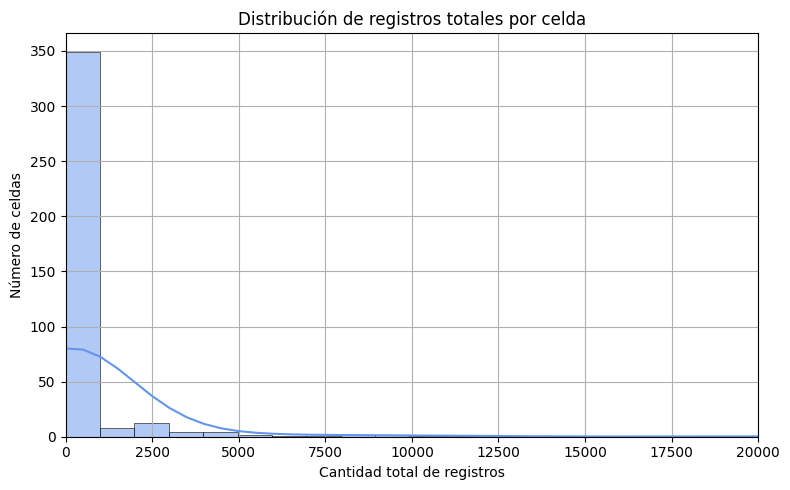

In [12]:
plt.figure(figsize=(8, 5))
sns.histplot(df['total_registros'], bins=100, kde=True, color='cornflowerblue')
plt.xlim(0, 20000)
plt.title("Distribución de registros totales por celda")
plt.xlabel("Cantidad total de registros")
plt.ylabel("Número de celdas")
plt.grid(True)
plt.tight_layout()
plt.show()


La cantidad de registros por celda es menor a 1000 en la gran mayoría de las celdas.

###### Histograma de riqueza por celda

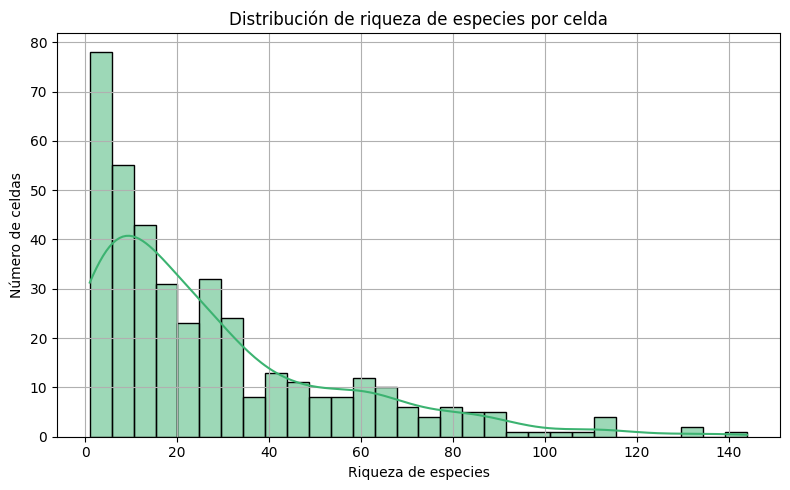

In [13]:
plt.figure(figsize=(8, 5))
sns.histplot(df['riqueza'], bins=30, kde=True, color='mediumseagreen')
plt.title("Distribución de riqueza de especies por celda")
plt.xlabel("Riqueza de especies")
plt.ylabel("Número de celdas")
plt.grid(True)
plt.tight_layout()
plt.show()


La mayor parte de las celdas con requistros tienen una baja cantidad de especies

### Borrar especies muy comunes o muy raras
Las especies presentes en más de un 90% de las celdas o en menos de un 2% de las celdas se consideran muy comunes o muy raras. Las borro para mejorar el modelado.

In [14]:
# Convertir 'grid_id' en índice:
df_ind = df.set_index('grid_id')

freq_rel = (df_ind > 0).sum(axis=0) / len(df_ind)
umbral_inf, umbral_sup = 0.02, 0.90
especies_útiles = freq_rel[(freq_rel >= umbral_inf) & (freq_rel <= umbral_sup)].index
df_idx = df_ind[especies_útiles]

### TF-IDF y normalización
Destaca las especies más raras y disminuye el efecto de las más comunes, para favorecer la diferenciación de las celdas al formase los clusters.

Se normaliza el resultado obtenido

In [15]:
# Separar la matriz de valores (sin índice) para pasar a TfidfTransformer
X = df_idx.values  # shape = (n_celdas, n_especies)

# Crear y ajustar el transformador TF–IDF
tfidf = TfidfTransformer(norm=None, use_idf=True, smooth_idf=True)
X_tfidf = tfidf.fit_transform(X).toarray()  # array NumPy, idéntica forma que X

# Normalizar cada fila para usar cosine distance
X_norm = normalize(X_tfidf, norm='l2', axis=1)

# 'Envolver' el array normalizado en un DataFrame que recupere el índice original
#  y los nombres de especie como columnas.
df_tfidf = pd.DataFrame(
    X_norm,
    index=df_idx.index,       # los grid_id originales
    columns=df_idx.columns    # nombres de especies
)


df_tfidf.head()


,Anairetes parulus,Anarhynchus falklandicus,Anas bahamensis,Anas flavirostris,Anas georgica,Anthus correndera,Aphrastura spinicauda,Aptenodytes patagonicus,Ardea ibis,Ardenna gravis,...,Tringa melanoleuca,Troglodytes musculus,Turdus falcklandii,Tyto furcata,Upucerthia dumetaria,Vanellus chilensis,Vultur gryphus,Zenaida auriculata,Zonibyx modestus,Zonotrichia capensis
grid_id,,,,,,,,,,,,,,,,,,,,,
25,0.000000,0.0,0.0,0.000000,0.019785,0.021280,0.000000,0.000000,0.0,0.150185,...,0.0,0.019331,0.017067,0.0,0.0,0.034545,0.019523,0.0,0.023789,0.014640
26,0.127041,0.0,0.0,0.089137,0.095427,0.034213,0.157463,0.000000,0.0,0.000000,...,0.0,0.155400,0.137202,0.0,0.0,0.055540,0.000000,0.0,0.076495,0.117688
27,0.000000,0.0,0.0,0.026418,0.056565,0.060841,0.084003,0.049078,0.0,0.107347,...,0.0,0.082903,0.073195,0.0,0.0,0.049383,0.083726,0.0,0.068014,0.062784
28,0.274709,0.0,0.0,0.000000,0.000000,0.000000,0.204295,0.000000,0.0,0.000000,...,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.248116,0.152691
70,0.014261,0.0,0.0,0.070043,0.149971,0.138264,0.042423,0.000000,0.0,0.020329,...,0.0,0.146534,0.138615,0.0,0.0,0.074816,0.000000,0.0,0.025761,0.110973


## Modelado

#### Preparar los datos para guardar los resultados de los modelos

In [16]:
# Copiar los datos para no modificar los datos preprocesados
X = df_tfidf.copy()
# Almacenar los nombres de las celdas
id_grid = X.index

# Cargar la grilla vacía
ruta_grilla = "../data/raw/grilla_tdf_vacia.gpkg"
gdf_grid = gpd.read_file(ruta_grilla)

### Construcción y entrenamiento de modelos
Se probaron cerca de 10 modelos distintos, mostrando unicamente los que dieron mejor resultado.

#### K-means

Buscar K óptimo

In [17]:
scores = {}
for k in range(2, 11):
    km = KMeans(n_clusters=k, random_state=0).fit(X)
    scores[k] = silhouette_score(X, km.labels_)

best_k = max(scores, key=scores.get)
print(f'Número ideal de clusters: {best_k}')

model_km = KMeans(n_clusters=best_k).fit(X)
labels_km = model_km.labels_

Número ideal de clusters: 4


#### Gaussian Mixture

In [18]:
# Partiendo de X_norm (TF–IDF + normalizado L2)
n_components = 3  # Cantidad óptima de clusters elegido luego de varias pruebas
gmm = GaussianMixture(n_components=n_components, covariance_type='full', random_state=0)
gmm.fit(X)
labels_gmm = gmm.predict(X)

#### Clustering espectral

In [19]:
# Usar directamente X_norm con k-vecinos para construir grafo
sp = SpectralClustering(
    n_clusters=4,
    affinity='nearest_neighbors',   # genera un grafo kNN
    n_neighbors=10,
    assign_labels='kmeans',
    random_state=0
)
labels_sp = sp.fit_predict(X)



### Evaluación de los modelos
Dado que los modelos son de aprendizaje no supervisado, no es posible utilizar métricas que comparen los resultados contra etiquetas reales. En su lugar, se utilizan métricas que evalúan cuan bien se agrupan los datos

##### Silhouette Score
- Evalúa la compactación y separación de los clusters.
- Rango: -1 a 1. Valores más cercanos a 1 indican mejor separación.

In [20]:
# K-means
silhouette_kmens = silhouette_score(X, labels_km)
print(f'silhouette para k-means: {silhouette_kmens}')

# Gaussian Mixture
silhouette_gaus = silhouette_score(X, labels_gmm)
print(f'silhouette para gausiano: {silhouette_gaus}')

# Clustering espectral
silhouette_espect = silhouette_score(X, labels_sp)
print(f'silhouette para espectral: {silhouette_espect}')

# Agrupar los resultados
silhouette_total = [silhouette_kmens, silhouette_gaus, silhouette_espect]

silhouette para k-means: 0.10206921563460998
silhouette para gausiano: 0.09380874687452652
silhouette para espectral: 0.0815677953405538


#### Davies-Bouldin Index
- Evalúa la distancia entre los centroides de los clusters.
- Valores más bajos indican mejores clusters.

In [21]:
# K-means
dbs_kmens = davies_bouldin_score(X, labels_km)
print(f'davies_bouldin para k-means: {dbs_kmens}')

# Gaussian Mixture
dbs_gaus = davies_bouldin_score(X, labels_gmm)
print(f'davies_bouldin para gausiano: {dbs_gaus}')

# Clustering espectral
dbs_espect = davies_bouldin_score(X, labels_sp)
print(f'davies_bouldin para espectral: {dbs_espect}')

# Agrupar los resultados
dbs_total = [dbs_kmens, dbs_gaus, dbs_espect]

davies_bouldin para k-means: 3.175398505288767
davies_bouldin para gausiano: 3.058984643611805
davies_bouldin para espectral: 2.777926535875331


#### Calinski-Harabasz Index
- Mide la dispersión entre y dentro de los clusters.
- Valores más altos indican mejores agrupamientos.

In [22]:
# K-means
chs_kmens = calinski_harabasz_score(X, labels_km)
print(f'calinski_harabasz para k-means: {chs_kmens}')

# Gaussian Mixture
chs_gaus = calinski_harabasz_score(X, labels_gmm)
print(f'calinski_harabasz para gausiano: {chs_gaus}')

# Clustering espectral
chs_espect = calinski_harabasz_score(X, labels_sp)
print(f'calinski_harabasz para espectral: {chs_espect}')

# Agrupar los resultados
chs_total = [chs_kmens, chs_gaus, chs_espect]

calinski_harabasz para k-means: 28.67482189404733
calinski_harabasz para gausiano: 31.21789650330717
calinski_harabasz para espectral: 23.68927034757616


#### Combinación de métricas
Para elegir el mejor modelo se escala las métricas, su suma Silhouette y Calinski-Harabasz, mientras que se resta Davies-Bouldin. El mayor valor indica el mejor modelo.

In [23]:
# Inicializo el escalador
scaler = MinMaxScaler()

# Invierto la métrica de Davies-Bouldin Index
dbs_inv = [-x for x in dbs_total]

# Uno las tres métricas
metricas = np.array([silhouette_total, dbs_inv, chs_total]).T

# Escalo los valores de cada métrica
metricas_norm = scaler.fit_transform(metricas)

# Combino las métricas normalizadas como promedio simple
puntaje_total = metricas_norm.mean(axis=1)

# Resultados
print(f'K-means: {puntaje_total[0]}')
print(f'Gaussian Mixture: {puntaje_total[1]}')
print(f'Clustering espectral: {puntaje_total[2]}')


K-means: 0.5540708863894563
Gaussian Mixture: 0.6299879780574257
Clustering espectral: 0.3333333333333333


Dado que el **modelo gaussiano** obtuvo un mejor puntaje, utilizo este modelo para los pasos siguientes

## Gráficos de resultados del modelo

#### Preparar los datos

In [24]:
# Crear un DataFrame con el resultado del modelo
df_clusters = pd.DataFrame({
    'grid_id': id_grid,
    'cluster': labels_gmm
})

# Unir el cluster a tu DataFrame de registros
df = df.merge(df_clusters, on='grid_id', how='left')


#### Riqueza por cluster

2025-06-24 10:16:18,938 [INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


2025-06-24 10:16:18,942 [INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


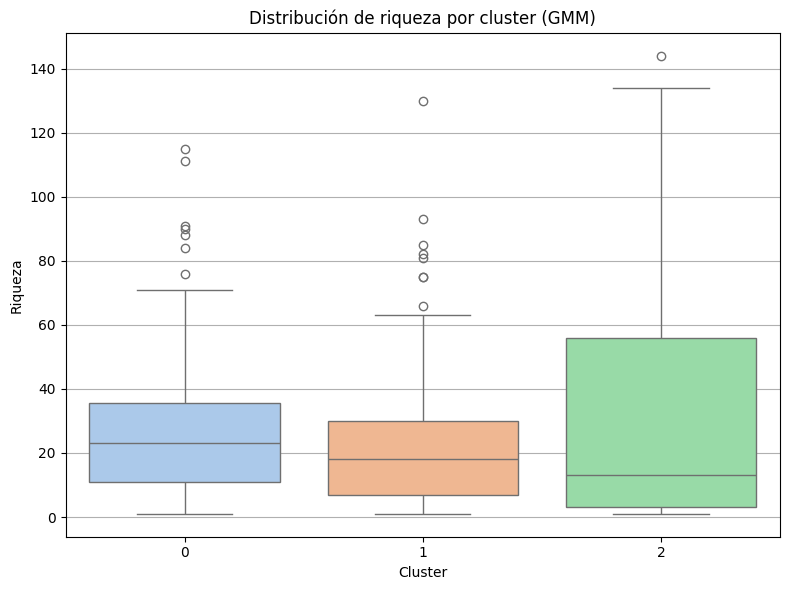

In [ ]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=df, x='cluster', y='riqueza', hue='cluster', palette='pastel', legend=False)
plt.title('Distribución de riqueza por cluster (GMM)')
plt.xlabel('Cluster')
plt.ylabel('Richness')
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

Se observa que la riqueza específica es similar entre los tres clusters del modelo

#### Celdas por cluster

2025-06-24 10:16:19,041 [INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-06-24 10:16:19,045 [INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


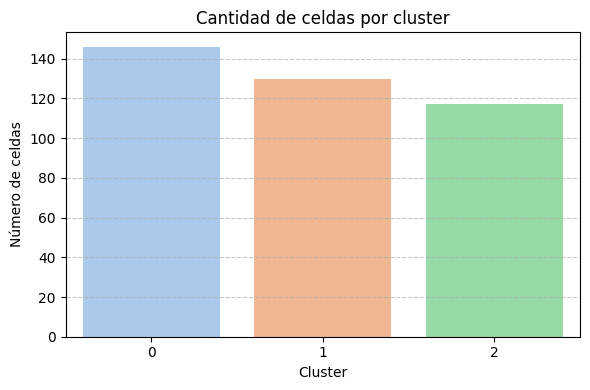

In [26]:
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='cluster', hue='cluster', palette='pastel', legend=False)
plt.title('Cantidad de celdas por cluster')
plt.xlabel('Cluster')
plt.ylabel('Número de celdas')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Se observa que los tres clusters tienen un tamaño similar, siendo el primero algo más grande.

## Exportar grilla espacial con los resultados del mejor modelo
Para permitir la visualización en el mapa

In [27]:
# Preparar los datos para la grilla espacial
clusters = labels_gmm
name_model = 'GaussianMixture'

In [28]:
# Agregar el resultado del modelo a la grilla espacial
gdf_grid = utils.merge_model_results(
    grid_gdf=gdf_grid,
    cell_ids=id_grid,
    cluster_labels=clusters,
    model_name=name_model
)

In [29]:
# Guardo el resultado en un nuevo .gpkg
ruta_salida = "../data/processed/grilla_tdf_clusters.gpkg"
gdf_grid.to_file(ruta_salida, driver="GPKG", layer="grilla_clusters")

print("Grilla con clusters guardada en:", ruta_salida)

2025-06-24 10:16:19,168 [INFO] Created 916 records
Grilla con clusters guardada en: ../data/processed/grilla_tdf_clusters.gpkg


## Mapear las celdas con mayor riqueza registrada por cluster

### Cálculo de puntaje de riqueza registrada por celda
EL puntaje para cada celda se calcula sumando el número de especies registradas en esa celda. Luego se estandariza fijando el valor 1 para la celda con mayor riqueza registrada en cada cluster. El resto de las celdas del cluster obtienen un puntaje igual a la proporción de riqueza registrada respecto a la celda con mayor riqueza registrada en el cluster.

#### Lista de especies prioritarias
Con el fin de priorizar especies de interés particular (por ejemplo, especies endémicas, carismáticas o en peligro de extinción), las especies de la siguiente lista tendrán un peso mayor al calcular el puntaje de riqueza.
Si no se quiere priorizar especies, dejar la lista vacía.
Las espcies se deben escribir como se muestra en el ejemplo: **"Canis familiaris"**


In [30]:
# Lista de especies prioritarias
PRIORITY_SPECIES = [
            "Campephilus magellanicus", "Vultur gryphus", "Chloephaga hybrida",
            "Chloephaga rubidiceps", "Daptrius albogularis",
            "Daptrius australis", "Cinclodes antarcticus",
            "Tachyeres pteneres", "Geositta antarctica",
            "Calidris canutus", "Aptenodytes patagonicus",
            "Thalassarche melanophris"
    ]

# Peso de las especies prioritarias (número entero)
PRIORITY_WEIGHT = 2

#### Exportar datos de puntaje de riqueza por celda clusterizada

In [31]:
postprocess_grid.main(
    priority_species=PRIORITY_SPECIES,
    priority_weight=PRIORITY_WEIGHT
)

2025-06-24 10:16:19,215 [INFO] Loaded grid: C:\Users\pablo\OneDrive\Estudio\Tecnicatura Cs datos e IA\3er cuatri\Aprendizaje automático\Parcial\Proyecto final\Potencial-ornitologico-fueguino\src\..\data\processed\grilla_tdf_clusters.gpkg
2025-06-24 10:16:19,222 [INFO] Loaded counts: 393 rows
2025-06-24 10:16:19,238 [INFO] Merged scores into grid
2025-06-24 10:16:19,276 [INFO] Created 916 records
2025-06-24 10:16:19,286 [INFO] Exported enriched grid to C:\Users\pablo\OneDrive\Estudio\Tecnicatura Cs datos e IA\3er cuatri\Aprendizaje automático\Parcial\Proyecto final\Potencial-ornitologico-fueguino\..\data\processed\grilla_riqueza.gpkg


### Crear mapas de riqueza registrada

#### Mapa estático

#### Mapa interactivo

In [2]:
interactive_map = postprocess_map.main()

2025-06-25 15:51:56,980 [INFO] Loaded enriched grid: C:\Users\pablo\OneDrive\Estudio\Tecnicatura Cs datos e IA\3er cuatri\Aprendizaje automático\Parcial\Proyecto final\Potencial-ornitologico-fueguino\data\processed\grilla_riqueza.gpkg
2025-06-25 15:51:57,318 [INFO] Saved interactive map to C:\Users\pablo\OneDrive\Estudio\Tecnicatura Cs datos e IA\3er cuatri\Aprendizaje automático\Parcial\Proyecto final\Potencial-ornitologico-fueguino\reports\figures\interactive_map.html


c:\Users\pablo\OneDrive\Estudio\Tecnicatura Cs datos e IA\3er cuatri\Aprendizaje automático\Parcial\Proyecto final\Potencial-ornitologico-fueguino\notebooks\..\src\postprocess_map.py:103: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_wgs.geometry.centroid.y.mean(),
c:\Users\pablo\OneDrive\Estudio\Tecnicatura Cs datos e IA\3er cuatri\Aprendizaje automático\Parcial\Proyecto final\Potencial-ornitologico-fueguino\notebooks\..\src\postprocess_map.py:104: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_wgs.geometry.centroid.x.mean()


In [3]:
interactive_map